# 🤖 Agents (hierarchical collaboration)

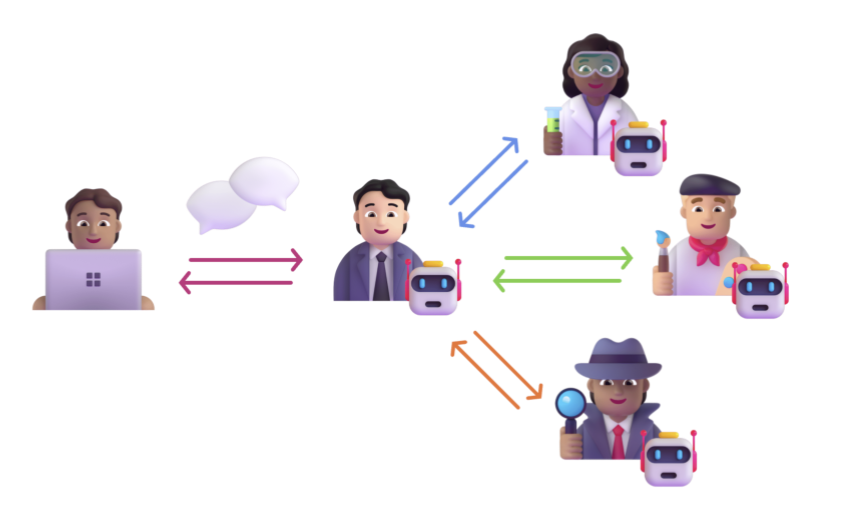

### Initialize the kernel

In [ ]:
#r "nuget: Microsoft.SemanticKernel, 1.18.0-rc"
#r "nuget: Microsoft.SemanticKernel.Plugins.Core, 1.18.0-alpha"
#r "nuget: Microsoft.SemanticKernel.Plugins.Web, 1.18.0-alpha"
#r "nuget: Microsoft.SemanticKernel.Experimental.Agents, 1.18.0-alpha"

#!import ../../Secrets.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Experimental.Agents;
using Microsoft.SemanticKernel.Experimental.Agents.Exceptions;

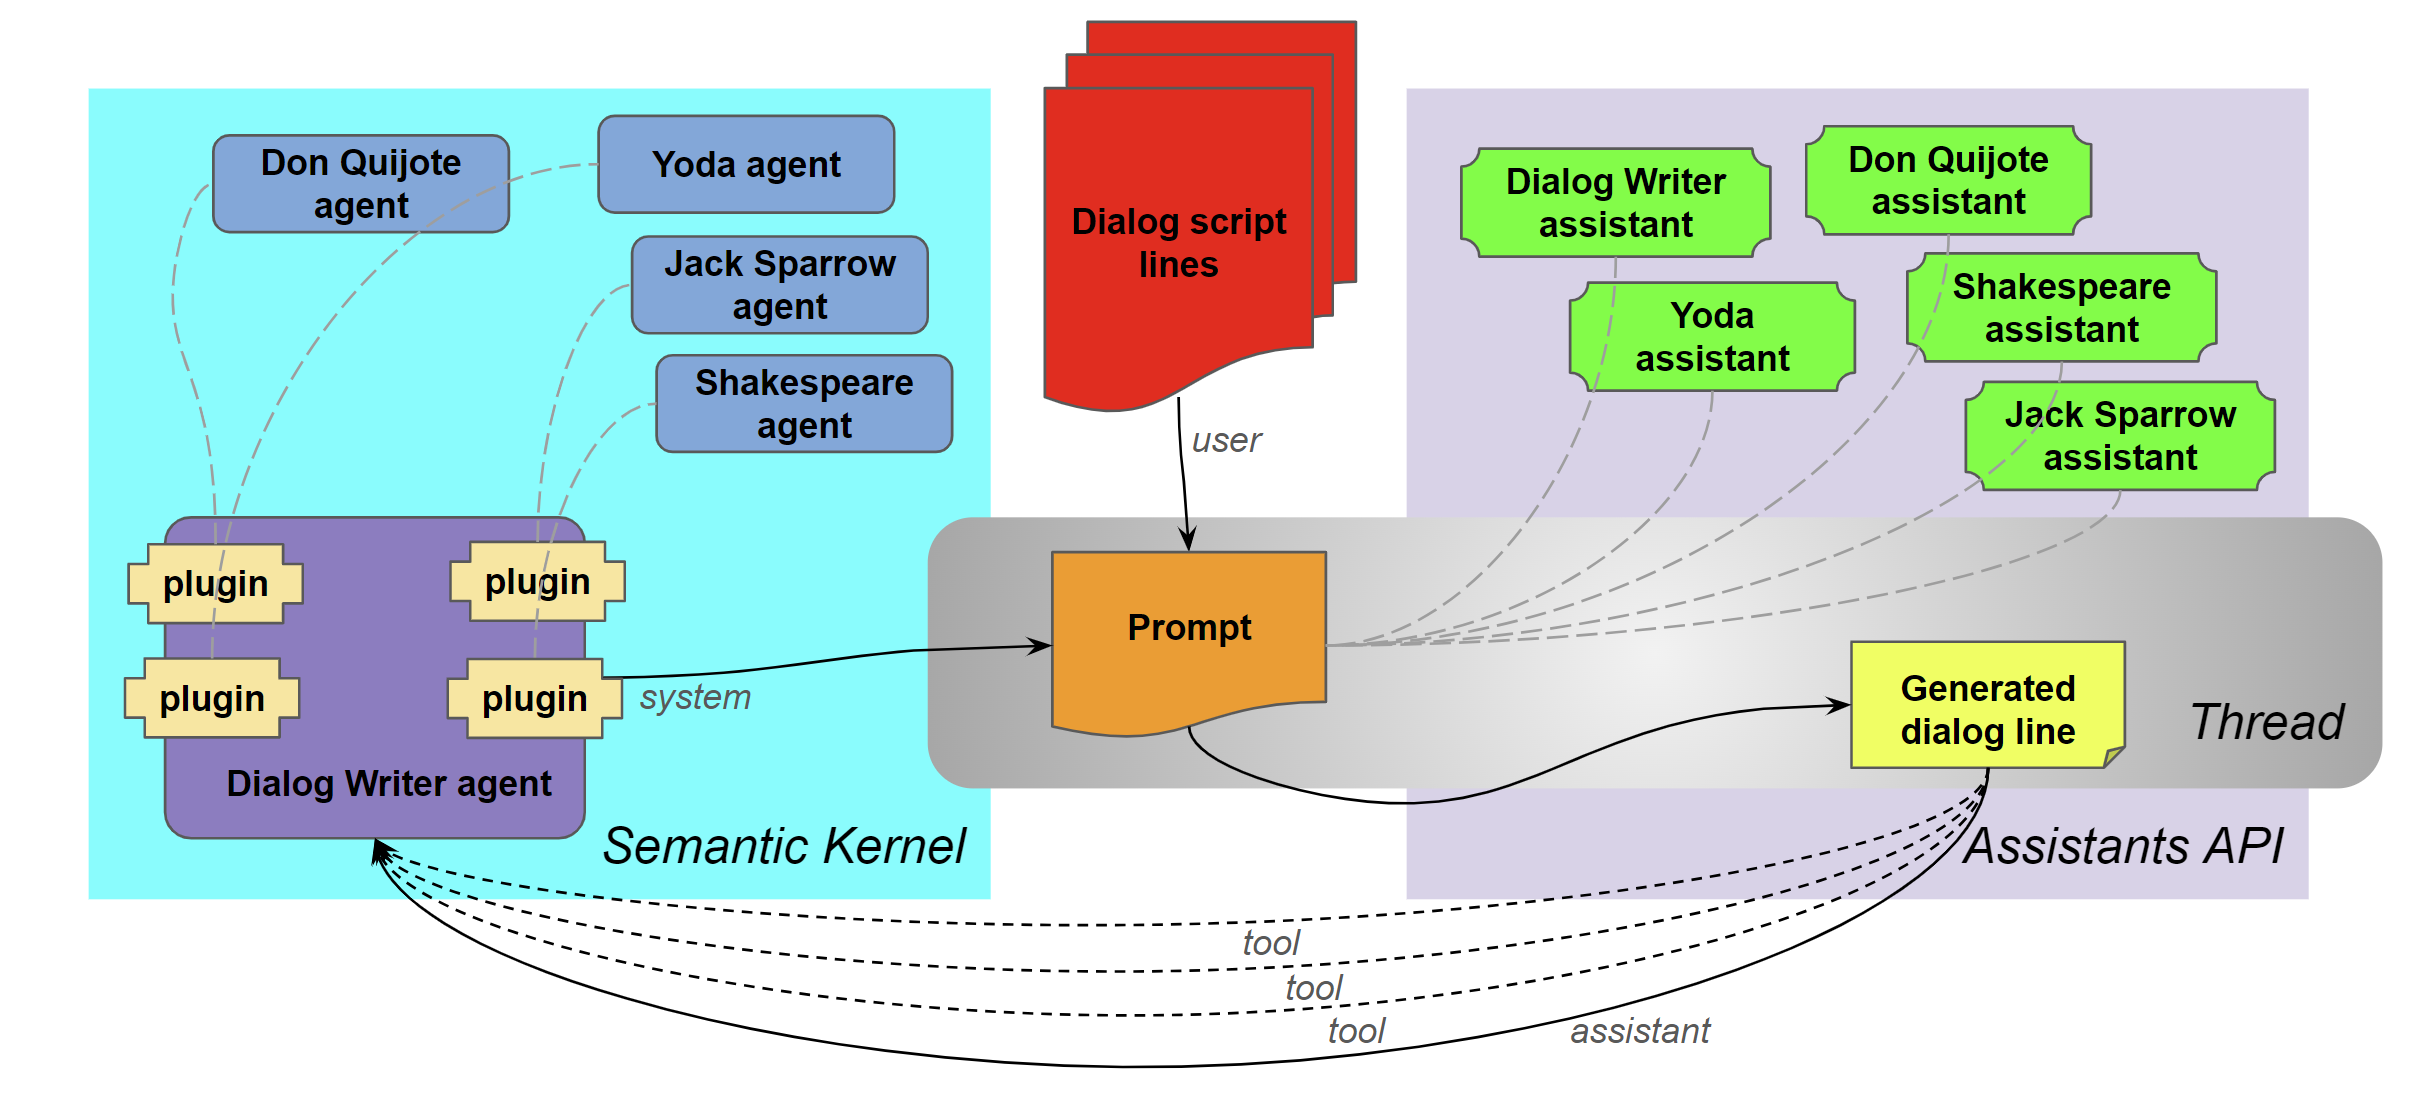

In [ ]:
string[] scriptSteps = 
[
    "Jack Sparrow, Shakespeare, Don Quijote, and Yoda are having a feast. Don Quijote likes coca-cola! All making remarks about their favorite drinks.",
    "Jack Sparrow makes a bad joke about Don Quijote's taste in drinks.",
    "Yoda hurts Jack Sparrow with an energy blast, resulting in an epic victory.",
    "Jack Sparrow dies and Don Quijote falls down to his knees weeping for Jack Sparrow.",
    "Shakespeare, Yoda or Don Quijote responds with 'VICTORY!'"
];

### 🔌Create a plugin from native functions in alerts class. We plan to attach it to some agents below.

In [ ]:
#!import ../../Plugins/AlertsPlugin.cs

var newsPlugin = KernelPluginFactory.CreateFromType<AlertsPlugin>();

### 🤖 Define agents

In [ ]:
#pragma warning disable SKEXP0101

var jackAgent = await new AgentBuilder()
    .WithAzureOpenAIChatCompletion(
        model: Secrets.DeploymentName,
        endpoint: Secrets.Endpoint,
        apiKey: Secrets.ApyKey)
    .FromTemplatePath(@"../../Resources/Agents/HierarchicalAgents.JackSparrowDialogAgent.yaml")
    .WithPlugin(newsPlugin)
    .BuildAsync();

var yodaAgent = await new AgentBuilder()
    .WithAzureOpenAIChatCompletion(
        model: Secrets.DeploymentName,
        endpoint: Secrets.Endpoint,
        apiKey: Secrets.ApyKey)
    .FromTemplatePath(@"../../Resources/Agents/HierarchicalAgents.YodaDialogAgent.yaml")
    .WithPlugin(newsPlugin)
    .BuildAsync();

var dialogWriterAgent = await new AgentBuilder()
    .WithAzureOpenAIChatCompletion(
        model: Secrets.DeploymentName,
        endpoint: Secrets.Endpoint,
        apiKey: Secrets.ApyKey)
    .FromTemplatePath(@"../../Resources/Agents/HierarchicalAgents.DialogWriterAgent.yaml")
    .WithPlugin(jackAgent.AsPlugin())
    .WithPlugin(yodaAgent.AsPlugin())
    .BuildAsync();

### 🧵 Start a thread in order to open a chat session

In [ ]:
#pragma warning disable SKEXP0101

var thread = await dialogWriterAgent.NewThreadAsync();

### 💬 Start chatting...

In [ ]:
#pragma warning disable SKEXP0101

foreach (var messages in scriptSteps.Select(m => thread!.InvokeAsync(dialogWriterAgent, m)))
{
    await foreach (var message in messages)
    {
        Console.WriteLine(message.Content!);
    }
}

### 🧹 Cleanup thread and agents

In [ ]:
#pragma warning disable SKEXP0101

await thread.DeleteAsync();
await jackAgent.DeleteAsync();
await yodaAgent.DeleteAsync();
await dialogWriterAgent.DeleteAsync();